<a href="https://colab.research.google.com/github/shizoda/education/blob/main/medical/unet_spleen.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
# MONAI（データロードと変換用）をインストール
!pip install -q "monai[tqdm, nibabel]" japanize-matplotlib

import os
import tempfile
import time
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from monai.data import DataLoader # <-- この行を変更

from monai.apps import DecathlonDataset
from monai.data import CacheDataset, decollate_batch
from monai.transforms import (
    AsDiscrete,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandCropByPosNegLabeld,
    ScaleIntensityRanged,
    Spacingd,
    EnsureTyped,
    EnsureType,
    SqueezeDimd,
)
from monai.utils import set_determinism

# 決定論的動作のシードを設定
set_determinism(seed=0)

In [9]:
class DoubleConv(nn.Module):
    """(Convolution => [Batch Norm] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class Down(nn.Module):
    """Downscaling with MaxPool then DoubleConv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

class Up(nn.Module):
    """Upscaling then DoubleConv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # bilinear=True の場合、Upsample + Conv を使用
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        # bilinear=False の場合、ConvTranspose2d を使用
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        # x1: U-NetのDecoderからの入力 (Upsample対象)
        # x2: U-NetのEncoderからのSkip connection
        x1 = self.up(x1)

        # 入力サイズが異なる場合、x2 (Skip) を x1 (Up) のサイズにクロップ
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])

        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class OutConv(nn.Module):
    """最後の出力レイヤー (1x1 Conv)"""
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    """ PyTorchによる2D U-Netの実装 """
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

In [ ]:
import os

# root_dir と TASK_NAME は前のセルで定義済みと仮定します
root_dir = tempfile.mkdtemp()
TASK_NAME = "Task09_Spleen"

# データが展開されるべきディレクトリパスを定義
data_dir = os.path.join(root_dir, TASK_NAME)
print(f"データディレクトリのターゲットパス: {data_dir}")

# ターゲットディレクトリ (例: /tmp/xxxx/Task09_Spleen) が存在しない場合のみダウンロードを実行
if not os.path.exists(data_dir):
    print(f"{data_dir} が見つかりません。ダウンロードを開始します...")

    # Spleenデータセット (Training) をダウンロード
    DecathlonDataset(
        root_dir=root_dir,
        task=TASK_NAME,
        section="training",
        download=True,
        cache_num=0, # キャッシュはデータセット作成時に行うためここでは0
    )

    # Spleenデータセット (Validation) をダウンロード
    DecathlonDataset(
        root_dir=root_dir,
        task=TASK_NAME,
        section="validation",
        download=True,
        cache_num=0,
    )
    print("ダウンロードと展開が完了しました。")

else:
    print(f"{data_dir} が既に存在するため、ダウンロードをスキップしました。")

データディレクトリのターゲットパス: /tmp/tmpatdkvlxx/Task09_Spleen
/tmp/tmpatdkvlxx/Task09_Spleen が見つかりません。ダウンロードを開始します...


Task09_Spleen.tar: 1.50GB [02:36, 10.3MB/s]                            

2025-10-24 13:25:24,431 - INFO - Downloaded: /tmp/tmpatdkvlxx/Task09_Spleen.tar


2025-10-24 13:25:27,231 - INFO - Verified 'Task09_Spleen.tar', md5: 410d4a301da4e5b2f6f86ec3ddba524e.
2025-10-24 13:25:27,232 - INFO - Writing into directory: /tmp/tmpatdkvlxx.


In [ ]:
# --- 3. データセットの準備 (続き) ---

# ファイルリストを取得 (セル3の実行後、root_dir と TASK_NAME は定義済み)
train_files = DecathlonDataset(
    root_dir=root_dir,
    task=TASK_NAME,
    section="training",
    transform=None,
    download=False, # すでにダウンロード済み
)
val_files = DecathlonDataset(
    root_dir=root_dir,
    task=TASK_NAME,
    section="validation",
    transform=None,
    download=False, # すでにダウンロード済み
)

print(f"学習データ数: {len(train_files)}")
print(f"検証データ数: {len(val_files)}")

# --- 3Dから2Dスライスをサンプリングする変換 (Coronalに変更) ---

PATCH_SIZE_2D = (128, 96) # Coronal平面 (R-L, S-I) のサイズとして流用

# 共通のCT強度スケーリング (腹部臓器ウィンドウ)
common_transforms = [
    LoadImaged(keys=["image", "label"], ensure_channel_first=True),
    ScaleIntensityRanged(
        keys=["image"],
        a_min=-150, a_max=250, # 腹部ウィンドウ
        b_min=0.0, b_max=1.0, clip=True,
    ),
    CropForegroundd(keys=["image", "label"], source_key="image"),
    Orientationd(keys=["image", "label"], axcodes="RAS"), # (R-L, A-P, S-I)
    Spacingd(
        keys=["image", "label"],
        pixdim=(1.5, 1.5, 2.0),
        mode=("bilinear", "nearest"),
    ),
]

# 学習用変換 (ランダムにCoronal 2Dスライスをサンプリング)
train_transforms = Compose(
    common_transforms + [
        # 3Dボリュームから (H, 1, W) のCoronalスライスをランダムにクロップ
        RandCropByPosNegLabeld(
            keys=["image", "label"],
            label_key="label",
            # ★ 修正: (H, 1, W) = (R-L, 1, S-I)
            spatial_size=(PATCH_SIZE_2D[0], 1, PATCH_SIZE_2D[1]),
            pos=1,
            neg=1,
            num_samples=1, # 1つの3Dボリュームから1スライスをサンプリング
            image_key="image",
            image_threshold=0,
        ),
        # ★ 修正: 最後の次元(Z軸)ではなく、Y軸(-2)を削除
        SqueezeDimd(keys=["image", "label"], dim=-2),
        EnsureTyped(keys=["image", "label"]),
    ]
)

# 検証用変換 (Coronal)
val_transforms = Compose(
    common_transforms + [
        RandCropByPosNegLabeld(
            keys=["image", "label"],
            label_key="label",
            # ★ 修正: (H, 1, W)
            spatial_size=(PATCH_SIZE_2D[0], 1, PATCH_SIZE_2D[1]),
            pos=1, neg=1,
            num_samples=1,
            image_key="image", image_threshold=0,
        ),
        # ★ 修正: Y軸(-2)を削除
        SqueezeDimd(keys=["image", "label"], dim=-2),
        EnsureTyped(keys=["image", "label"]),
    ]
)

# CacheDataset と DataLoader
train_ds = CacheDataset(
    data=train_files, transform=train_transforms, cache_rate=1.0, num_workers=4
)
val_ds = CacheDataset(
    data=val_files, transform=val_transforms, cache_rate=1.0, num_workers=4
)

BATCH_SIZE = 16
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

print("DataLoaderの準備が完了しました。(Coronalスライス)")

In [ ]:
# Dice Loss の実装
class DiceLoss(nn.Module):
    def __init__(self, smooth=1e-6):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, logits, targets):
        # ロジットをシグモイド関数で確率 (0-1) に変換
        probs = torch.sigmoid(logits)

        # 2Dデータ (B, 1, H, W) をフラット化
        probs_flat = probs.view(probs.size(0), -1)
        targets_flat = targets.view(targets.size(0), -1)

        intersection = (probs_flat * targets_flat).sum()
        union = probs_flat.sum() + targets_flat.sum()

        dice = (2. * intersection + self.smooth) / (union + self.smooth)
        return 1 - dice # 損失なので 1 から引く

# デバイスの設定
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# モデルの初期化 (入力1ch, 出力1ch)
model = UNet(n_channels=1, n_classes=1).to(device)

# オプティマイザ
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# 損失関数 (BCE + Dice)
# BCEWithLogitsLoss: sigmoid + BCE をまとめて計算 (数値的安定性)
bce_loss_fn = nn.BCEWithLogitsLoss()
dice_loss_fn = DiceLoss()

def combined_loss(logits, targets):
    """BCEとDiceを組み合わせた損失"""
    bce = bce_loss_fn(logits, targets)
    dice = dice_loss_fn(logits, targets)
    return bce + dice

In [6]:


max_epochs = 30 # 時間短縮のためエポック数を少なめに設定
epoch_loss_values = []

print("🚀 トレーニング開始...")
start_time = time.time()

for epoch in range(max_epochs):
    model.train()
    epoch_loss = 0
    step = 0

    for batch_data in train_loader:
        step += 1
        # batch_data["image"] の形状: (num_samples, C, H, W)
        inputs, labels = (
            batch_data["image"].to(device),
            batch_data["label"].to(device), # ラベルは (0.0 or 1.0)
        )

        optimizer.zero_grad()

        # モデルの出力 (ロジット)
        outputs = model(inputs)

        loss = combined_loss(outputs, labels)

        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"Epoch {epoch + 1}/{max_epochs}, 経過時間: {time.time() - start_time:.2f}秒, 平均損失: {epoch_loss:.4f}")

print(f"🏁 トレーニング完了。所要時間: {time.time() - start_time:.2f}秒")

🚀 トレーニング開始...
Epoch 1/30, 経過時間: 7.55秒, 平均損失: 1.6815
Epoch 2/30, 経過時間: 12.87秒, 平均損失: 1.5632
Epoch 3/30, 経過時間: 19.02秒, 平均損失: 1.3762
Epoch 4/30, 経過時間: 24.10秒, 平均損失: 1.5259
Epoch 5/30, 経過時間: 29.66秒, 平均損失: 1.2748
Epoch 6/30, 経過時間: 34.94秒, 平均損失: 1.2981
Epoch 7/30, 経過時間: 39.95秒, 平均損失: 1.4464
Epoch 8/30, 経過時間: 46.16秒, 平均損失: 1.4647
Epoch 9/30, 経過時間: 51.14秒, 平均損失: 1.4100
Epoch 10/30, 経過時間: 57.25秒, 平均損失: 1.3587
Epoch 11/30, 経過時間: 62.26秒, 平均損失: 1.0928
Epoch 12/30, 経過時間: 67.63秒, 平均損失: 1.2982
Epoch 13/30, 経過時間: 73.04秒, 平均損失: 1.3225
Epoch 14/30, 経過時間: 78.11秒, 平均損失: 1.3631
Epoch 15/30, 経過時間: 84.16秒, 平均損失: 1.3014
Epoch 16/30, 経過時間: 89.37秒, 平均損失: 1.3379
Epoch 17/30, 経過時間: 95.41秒, 平均損失: 1.2980
Epoch 18/30, 経過時間: 100.47秒, 平均損失: 0.9883
Epoch 19/30, 経過時間: 105.97秒, 平均損失: 1.0027
Epoch 20/30, 経過時間: 111.38秒, 平均損失: 1.1377
Epoch 21/30, 経過時間: 116.36秒, 平均損失: 1.2705
Epoch 22/30, 経過時間: 122.37秒, 平均損失: 1.2547
Epoch 23/30, 経過時間: 127.51秒, 平均損失: 1.2817
Epoch 24/30, 経過時間: 133.58秒, 平均損失: 0.9613
Epoch 25/30, 経過時間: 138.78秒, 平

🎨 検証データ（3D全体）からベストCoronalスライスを推論します...


/tmp/ipython-input-2683896645.py:101: UserWarning: Glyph 30151 (\N{CJK UNIFIED IDEOGRAPH-75C7}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2683896645.py:101: UserWarning: Glyph 20363 (\N{CJK UNIFIED IDEOGRAPH-4F8B}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2683896645.py:101: UserWarning: Glyph 20837 (\N{CJK UNIFIED IDEOGRAPH-5165}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2683896645.py:101: UserWarning: Glyph 21147 (\N{CJK UNIFIED IDEOGRAPH-529B}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2683896645.py:101: UserWarning: Glyph 30906 (\N{CJK UNIFIED IDEOGRAPH-78BA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2683896645.py:101: UserWarning: Glyph 29575 (\N{CJK UNIFIED IDEOGRAPH-7387}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2683896645.py:101: UserWarning: Glyph 12510 (\N{KATAKANA LETTER MA}) missin

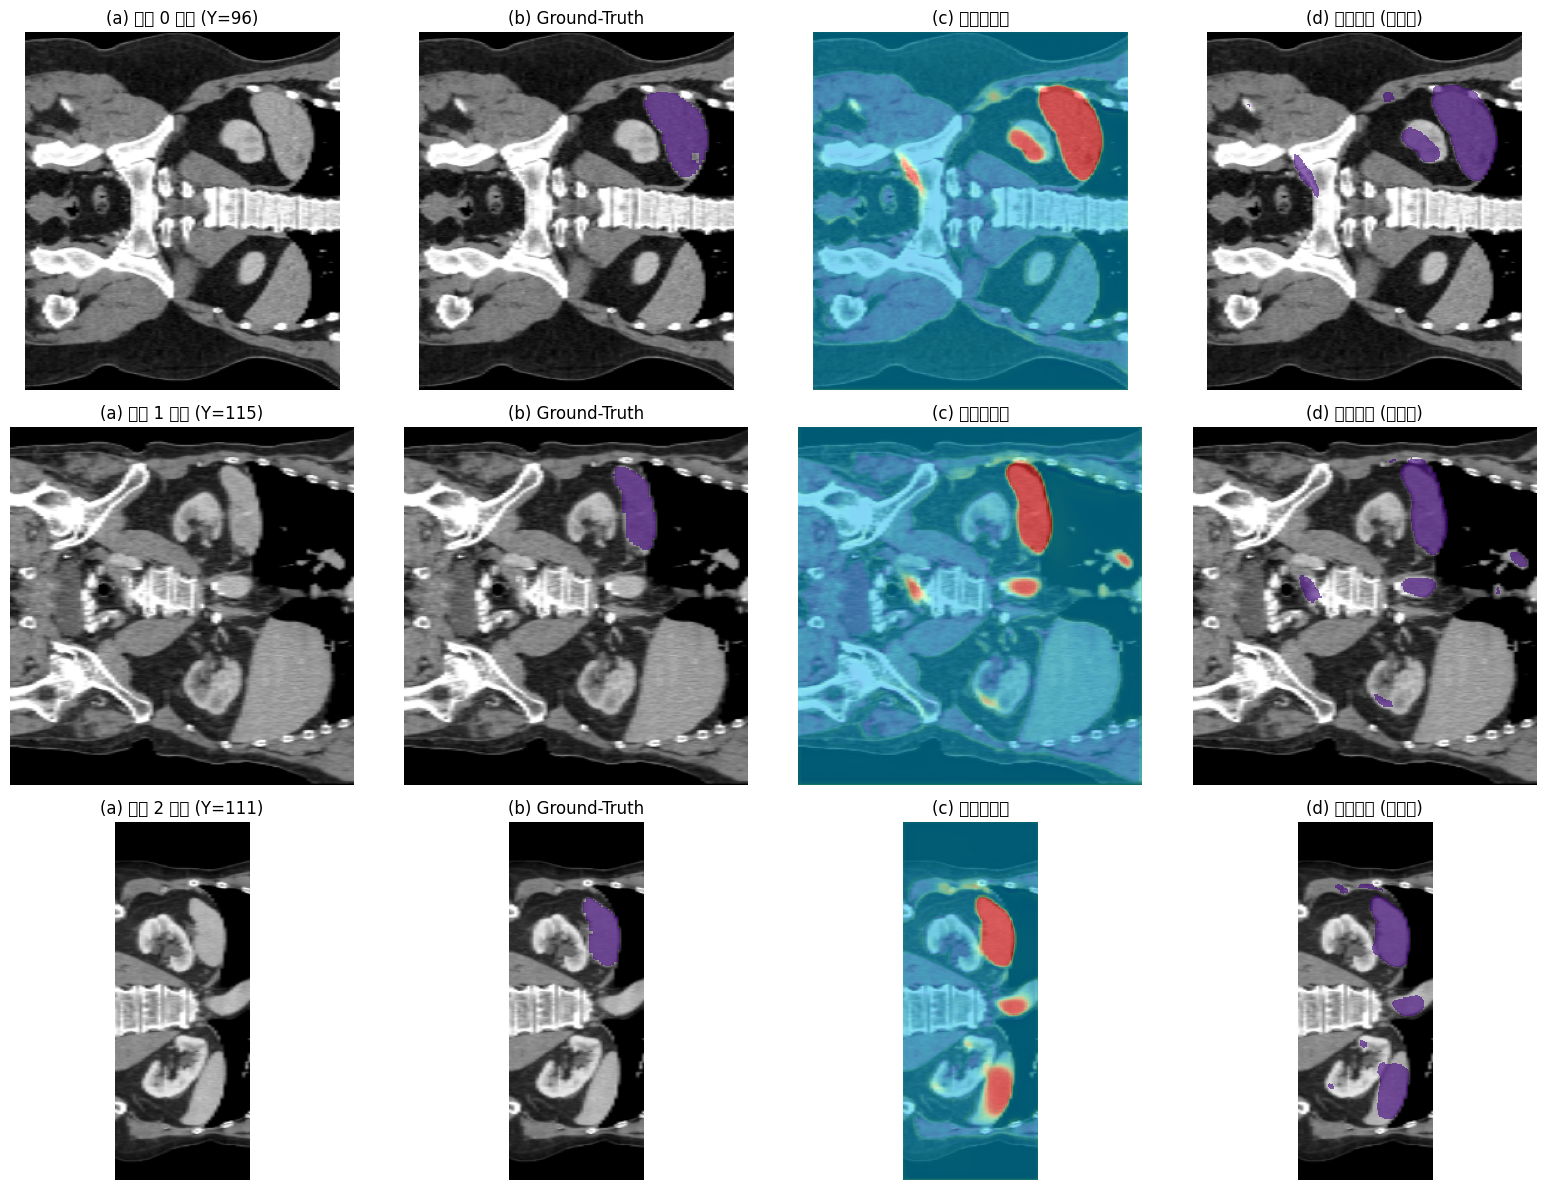

In [7]:
import warnings

# ⭐️ マスクの色をここで指定 (b) と (d) で使用
MASK_COLOR = 'Purples'
# ⭐️ (c) 確率マップの色を指定
PROBABILITY_MAP_COLOR = 'rainbow'


print("🎨 検証データ（3D全体）からベストCoronalスライスを推論します...")

# --- 推論用の変換パイプラインを定義 ---
inference_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"], ensure_channel_first=True),
        ScaleIntensityRanged(
            keys=["image"],
            a_min=-150, a_max=250,
            b_min=0.0, b_max=1.0, clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.5, 1.5, 2.0),
            mode=("bilinear", "nearest"),
        ),
        EnsureTyped(keys=["image", "label"]),
    ]
)

# 検証データのファイルリストから、最初の3症例を表示
num_to_show = 3
plt.figure("結果の可視化 (Coronal)", figsize=(16, 4 * num_to_show))

with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    for i, file_data in enumerate(val_files[:num_to_show]):

        # 1. 3Dボリューム全体をロード
        data_dict = inference_transforms(file_data)
        image_vol = data_dict["image"]
        label_vol = data_dict["label"]

        # 2. ベストなCoronalスライス(XZ平面)を見つける
        label_sum_per_coronal_slice = torch.sum(label_vol[0], dim=(0, 2))
        best_slice_idx_y = torch.argmax(label_sum_per_coronal_slice).item()

        # 3. ベストスライスを抽出 (2D)
        img_slice = image_vol[0, :, best_slice_idx_y, :].cpu().numpy()
        label_slice = label_vol[0, :, best_slice_idx_y, :].cpu().numpy()

        # 4. 推論
        model.eval()
        with torch.no_grad():
            input_tensor = torch.tensor(img_slice).unsqueeze(0).unsqueeze(0).to(device)
            output_logits = model(input_tensor)
            output_probs = torch.sigmoid(output_logits)

            pred_prob_slice = output_probs.cpu().numpy()[0, 0]
            pred_slice = (output_probs > 0.5).cpu().numpy()[0, 0]

        # 5. ★ 修正: 表示用にスライスを変換 (左90度回転 -> 左右反転)
        img_slice = np.fliplr(np.rot90(img_slice))
        label_slice = np.fliplr(np.rot90(label_slice))
        pred_prob_slice = np.fliplr(np.rot90(pred_prob_slice))
        pred_slice = np.fliplr(np.rot90(pred_slice))

        # --- (a) 入力画像 (Coronal) ---
        plt.subplot(num_to_show, 4, i * 4 + 1)
        plt.title(f"(a) 症例 {i} 入力 (Y={best_slice_idx_y})")
        plt.imshow(img_slice, cmap="gray")
        plt.axis("off")

        # --- (b) Ground-truth (Coronal) ---
        plt.subplot(num_to_show, 4, i * 4 + 2)
        plt.title("(b) Ground-Truth")
        plt.imshow(img_slice, cmap="gray")
        masked_label = np.ma.masked_where(label_slice == 0, label_slice)
        plt.imshow(masked_label, cmap=MASK_COLOR, alpha=0.6, interpolation='none', vmin=0, vmax=1)
        plt.axis("off")

        # --- (c) 確率マップ (Rainbow) ---
        plt.subplot(num_to_show, 4, i * 4 + 3)
        plt.title("(c) 確率マップ")
        plt.imshow(img_slice, cmap="gray")
        plt.imshow(pred_prob_slice, cmap=PROBABILITY_MAP_COLOR, alpha=0.5, interpolation='none', vmin=0, vmax=1)
        plt.axis("off")

        # --- (d) 予測結果 (二値化) ---
        plt.subplot(num_to_show, 4, i * 4 + 4)
        plt.title("(d) 予測結果 (二値化)")
        plt.imshow(img_slice, cmap="gray")
        masked_pred = np.ma.masked_where(pred_slice == 0, pred_slice)
        plt.imshow(masked_pred, cmap=MASK_COLOR, alpha=0.6, interpolation='none', vmin=0, vmax=1)
        plt.axis("off")

plt.tight_layout()
plt.show()